In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
import pylab
import glob
from scipy import interpolate
import math

#PIC values
epsilon_PIC = np.zeros(12)
epsilon_PIC[0]  = 60.
epsilon_PIC[1]  = 30.
epsilon_PIC[2]  = 45.
epsilon_PIC[3]  = 55.
epsilon_PIC[4]  = 50.
epsilon_PIC[5]  = 40.
epsilon_PIC[6]  = 38.
epsilon_PIC[7]  = 3.
epsilon_PIC[8]  = 8.
epsilon_PIC[9]  = 15.
epsilon_PIC[10] = 100.
epsilon_PIC[11] = 200.

sigma_PIC = np.zeros(12)
sigma_PIC[0]  = 0.78
sigma_PIC[1]  = 0.988
sigma_PIC[2]  = 0.92
sigma_PIC[3]  = 0.81
sigma_PIC[4]  = 0.85
sigma_PIC[5]  = 0.97
sigma_PIC[6]  = 0.975
sigma_PIC[7]  = 0.999
sigma_PIC[8]  = 0.998
sigma_PIC[9]  = 0.997
sigma_PIC[10] = 0.66
sigma_PIC[11] = 0.58

Phi_PIC = np.zeros(12)
Phi_PIC[0]  = 150.
Phi_PIC[1]  = 50.
Phi_PIC[2]  = 90.
Phi_PIC[3]  = 130.
Phi_PIC[4]  = 100.
Phi_PIC[5]  = 70.
Phi_PIC[6]  = 57.
Phi_PIC[7]  = 34.
Phi_PIC[8]  = 37.
Phi_PIC[9]  = 42.
Phi_PIC[10] = 155.
Phi_PIC[11] = 159.

Te_PIC = np.zeros(12)
Te_PIC[0]  = 47.
Te_PIC[1]  = 35.
Te_PIC[2]  = 43.
Te_PIC[3]  = 47.
Te_PIC[4]  = 46.
Te_PIC[5]  = 39.
Te_PIC[6]  = 37.5
Te_PIC[7]  = 32.
Te_PIC[8]  = 33.
Te_PIC[9]  = 34.
Te_PIC[10] = 48.
Te_PIC[11] = 48.1


In [2]:

#physical parameters
q=1.6e-19
me=9e-31
mi=131*1.67e-27

sigma_0 = 0.5
ne = 3e17
Te_refl=1.0
B0  = 20.0e-3
E0  = 2.0e4
nu_m=1e7
Lx = 5.12E-003
Ly = 2.0E-002
Lz = 1.002E-002
sigma_max = 2.9

lim = 13.3381

#define constant physical values
#omega_ce
omega_c = q*B0/me
print('omega_c',omega_c)

#v_zi
v_zi = math.sqrt( (2.0*q*E0*Lz) / mi )
print('v_zi',v_zi)

#mu_cla
mu_cla = q /( me*nu_m*(1.0 + (omega_c**2 / nu_m**2)))
print('mu_cla',mu_cla)

#define epsilon_star
step = 0.1
epsilon = np.arange(lim,200,step, dtype='f')
print(epsilon)

#define Te_eq, Ploss_eq, Ploss_eReq to be filled up
Te_eq = np.arange(lim,200,step, dtype='f')
Ploss_eq = np.arange(lim,200,step, dtype='f')
Ploss_eReq = np.arange(lim,200,step, dtype='f')

#drift velocity
v_d = E0/B0
print(v_d)


omega_c 3555555555.555555
v_zi 17121.03300015412
mu_cla 0.1406238876430763
[  13.33810043   13.43809986   13.53809929 ...,  199.73703003  199.83703613
  199.93704224]
1000000.0


In [5]:
%load_ext snakeviz

In [7]:
%%snakeviz
#for each epsilon get the physical values needed to obtain Te_eq

for i in range(np.shape(epsilon)[0]):
    #physical values needed
    Te     = np.arange(0.01,0.99*epsilon[i],0.01) #[eV] electron temperature
    sigma  = ( sigma_0 + Te /epsilon[i]* (1.-sigma_0) ) + np.exp(-4.8*epsilon[i]/Te)*( sigma_max - sigma_0 - ( 1.-sigma_0 )*( 9.6*epsilon[i] + 2.*Te )/( 2.*epsilon[i] ) )#SEE yield
    Phi    = Te * np.log( (1.-sigma)* np.sqrt(mi /(2. * math.pi*me))) + Te*0.5 #[V] plasma potential
    v_th   = np.sqrt(8.*q*Te/(math.pi*me)) #[m/s] thermal velocity of electrons
    cs     = np.sqrt(q*Te/mi) #[m/s] ion sound speed
    mu_eff = mu_cla*( 1. + ( q*B0*v_zi*Te ) / ( me*nu_m*E0*4.*math.sqrt(6)*cs*Lz ) ) #[m2/(Vs)] electron cross field mobility

    Gamma_eR = 0.25*ne*v_th*np.exp(-Phi/Te)
    Q_eR     = q*Gamma_eR*(Phi+2.*Te) - q*sigma*Gamma_eR*(Phi+2.*Te_refl)
    Ploss_eR = Q_eR*2.*Lz*Lx

    Gamma_ez = ne*mu_eff*E0
    #Q_ez     = q*Gamma_ez*2.*Te #si pertes sur les deux parois en (Oz), rajouter un 2. devant l'expression
    Q_ez     = q*Gamma_ez*(3/2*Te)  #si pertes sur une parois en (Oz),/
    Ploss_ez = Q_ez*Ly*Lx

    Ploss    = Ploss_ez + Ploss_eR

    Pabs     = q*ne*mu_eff*E0**2*Lx*Ly*Lz

    diff_P   = np.abs(Pabs - Ploss)

    if epsilon[i] > 100000000:
        plt.close()
        plt.plot(Te,diff_P)
        plt.title(epsilon[i])
        plt.show()

    if diff_P[int(np.argmin(diff_P))] < 4:
        Te_eq[i]    = Te[int(np.argmin(diff_P))]
        Ploss_eq[i] = Ploss[int(np.argmin(diff_P))]
        Ploss_eReq[i] = Ploss_eR[int(np.argmin(diff_P))]
    else:
        Te_eq[i]    = 0.0
        Ploss_eq[i] = 0.0
        Ploss_eReq[i] = 0.0


 
*** Profile stats marshalled to file '/tmp/tmpc6f30lru'. 


ImportError: No module named 'snakeviz'

0.02
17121.03300015412
0.1406238876430763
v_dz = [ 72712.29114899  63132.44673891  69671.69921633  72712.29114899
  71964.67806699  66486.07570829  65249.57745967  60489.39986989
  61383.66904536  62264.48826512  73451.99231335  73525.5368565 ]  m/s


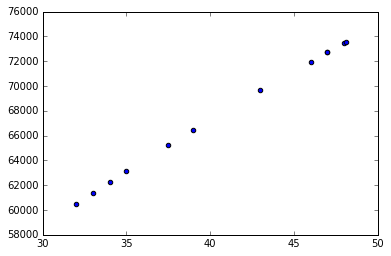

In [4]:
print(B0)
print(v_zi)
print(mu_cla)

Te = Te_PIC
cs     = np.sqrt(q*Te/mi) #[m/s] ion sound speed
mu_eff = mu_cla*( 1. + ( q*B0*v_zi*Te ) / ( me*nu_m*E0*4.*math.sqrt(6)*cs*Lz ) )
print("v_dz =",mu_eff*E0," m/s")

plt.scatter(Te,mu_eff*E0)
plt.show()

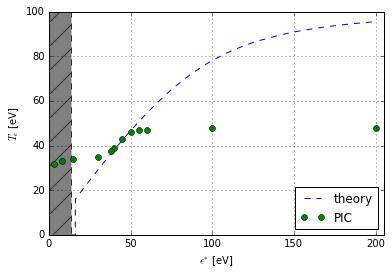

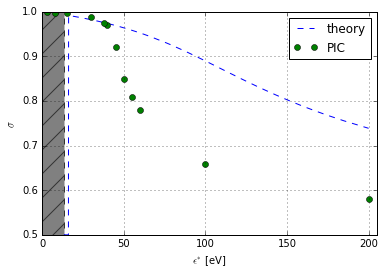

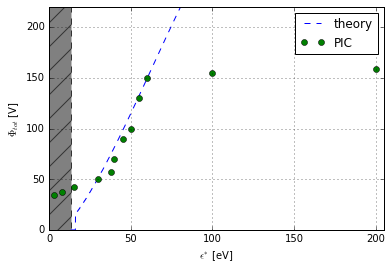

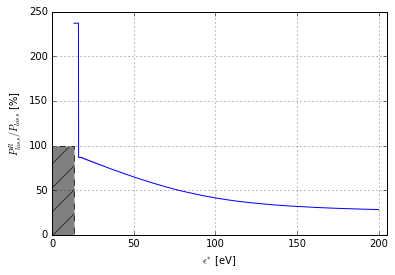

In [5]:
#plot Te_eq = f(epsilon)
plt.close()

plt.plot(epsilon,Te_eq,linestyle='--',label='theory')
plt.plot(epsilon_PIC,Te_PIC,marker='o',linestyle='none',label='PIC')

plt.xlabel('$\epsilon^{*}$ [eV]')
plt.ylabel('$T_e$ [eV]')
plt.legend(loc='lower right')
plt.grid()
plt.xlim([0,205])

currentAxis = plt.gca()
currentAxis.add_patch(patches.Rectangle( (0.0,0.0), lim, 100., hatch='/', edgecolor='0.2', facecolor='0.5', linestyle='--'))

plt.savefig('Te_epsilon.png')
plt.show()

#obtain the SEE rate
rate = ( sigma_0 + Te_eq /epsilon* (1. - sigma_0) ) + np.exp(-4.8*epsilon/Te_eq)*( sigma_max - sigma_0 - ( 1.-sigma_0 )*( 9.6*epsilon + 2.*Te_eq )/( 2.*epsilon ) )
plt.close()

plt.plot(epsilon,rate,linestyle='--',label='theory')
plt.plot(epsilon_PIC,sigma_PIC,marker='o',linestyle='none',label='PIC')

plt.xlabel('$\epsilon^{*}$ [eV]')
plt.ylabel('$\sigma$')
plt.legend(loc='best')
plt.grid()
plt.xlim([0,205])
#plt.ylim([0.7,1.1])

currentAxis = plt.gca()
currentAxis.add_patch(patches.Rectangle( (0.0,0.0), lim, 100., hatch='/', edgecolor='0.2', facecolor='0.5', linestyle='--'))

plt.savefig('sigma_epsilon.png')
plt.show()

#obtain the sheath potential
Phi_tot = Te_eq * np.log( (1.-rate)* np.sqrt(mi /(2. * math.pi*me))) + Te_eq*0.5
plt.close()

plt.plot(epsilon,Phi_tot,linestyle='--',label='theory')
plt.plot(epsilon_PIC,Phi_PIC,marker='o',linestyle='none',label='PIC')

plt.xlabel('$\epsilon^{*}$ [eV]')
plt.ylabel('$\Phi_{tot}$ [V]')
plt.legend(loc='best')
plt.grid()
plt.xlim([0,205])
plt.ylim([0.0,220.])

currentAxis = plt.gca()
currentAxis.add_patch(patches.Rectangle( (0.0,0.0), lim, 500., hatch='/', edgecolor='0.2', facecolor='0.5', linestyle='--'))

plt.savefig('Phi_epsilon.png')
plt.show()

#plot the Ploss_R/Ploss = f(epsilon)
plt.close()

plt.plot(epsilon,Ploss_eReq/Ploss_eq*100.)

plt.ylabel('$P_{loss}^R / P_{loss}$ [%]')
plt.xlabel('$\epsilon^{*}$ [eV]')
plt.grid()
plt.xlim([0,205])

currentAxis = plt.gca()
currentAxis.add_patch(patches.Rectangle( (0.0,0.0), lim, 100., hatch='/', edgecolor='0.2', facecolor='0.5', linestyle='--'))

plt.savefig('Ploss_Plosstot.png')
plt.show()


2.5

3.4499999999999997